In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

import pandas as pd
import statsmodels.api as sm
import matplotlib

import sys
import os

# Local imports
src_dir = os.path.abspath('../')
os.chdir(src_dir)
sys.path.append(src_dir)
from src.config import *

# Matplotlib settings
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
plt.style.use('fivethirtyeight')

## The Data

In [3]:
excel_data_file_name = 'Superstore.xls'
df = pd.read_excel(os.path.join(DATA_DIR, excel_data_file_name))
df.sample(5)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
9301,9302,US-2015-163433,2015-04-18,2015-04-22,Second Class,MP-17965,Michael Paige,Corporate,United States,Mcallen,...,78501,Central,TEC-PH-10001870,Technology,Phones,Lunatik TT5L-002 Taktik Strike Impact Protecti...,97.968,2,0.2,6.1230
6212,6213,CA-2017-149944,2017-11-12,2017-11-16,Second Class,MB-17305,Maria Bertelson,Consumer,United States,Longview,...,98632,West,OFF-FA-10003495,Office Supplies,Fasteners,Staples,18.240,3,0.0,9.1200
4743,4744,CA-2017-168123,2017-03-05,2017-03-05,Same Day,JD-16060,Julia Dunbar,Consumer,United States,Rochester,...,55901,Central,OFF-FA-10002763,Office Supplies,Fasteners,Advantus Map Pennant Flags and Round Head Tacks,7.900,2,0.0,2.5280
2661,2662,CA-2017-123372,2017-11-28,2017-12-02,Standard Class,DG-13300,Deirdre Greer,Corporate,United States,New York City,...,10035,East,OFF-EN-10003055,Office Supplies,Envelopes,Blue String-Tie & Button Interoffice Envelopes...,79.960,2,0.0,35.9820
9420,9421,CA-2017-152926,2017-10-02,2017-10-04,Second Class,SC-20695,Steve Chapman,Corporate,United States,Houston,...,77041,Central,OFF-AP-10001947,Office Supplies,Appliances,Acco 6 Outlet Guardian Premium Plus Surge Supp...,21.984,6,0.8,-56.0592


In [4]:
furniture = df.loc[df['Category'] == 'Furniture']
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

### Data Preprocessing

In [5]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

### Indexing with Time Series Data

In [6]:
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-13', '2014-01-14', '2014-01-16',
               '2014-01-19', '2014-01-20',
               ...
               '2017-12-28', '2017-12-28', '2017-12-28', '2017-12-29',
               '2017-12-29', '2017-12-29', '2017-12-29', '2017-12-29',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=2121, freq=None)

In [7]:
y = furniture['Sales'].resample('MS').mean()

### Visualizing Furniture Sales Time Series Data

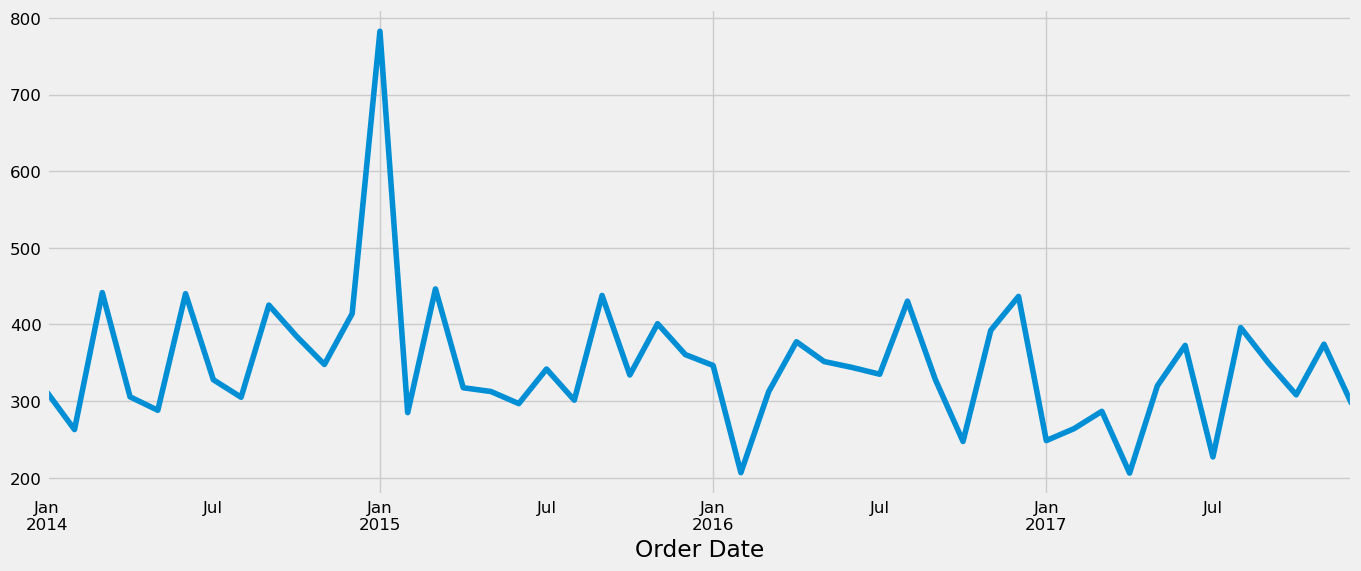

In [8]:
y.plot(figsize=(15, 6))
plt.show()

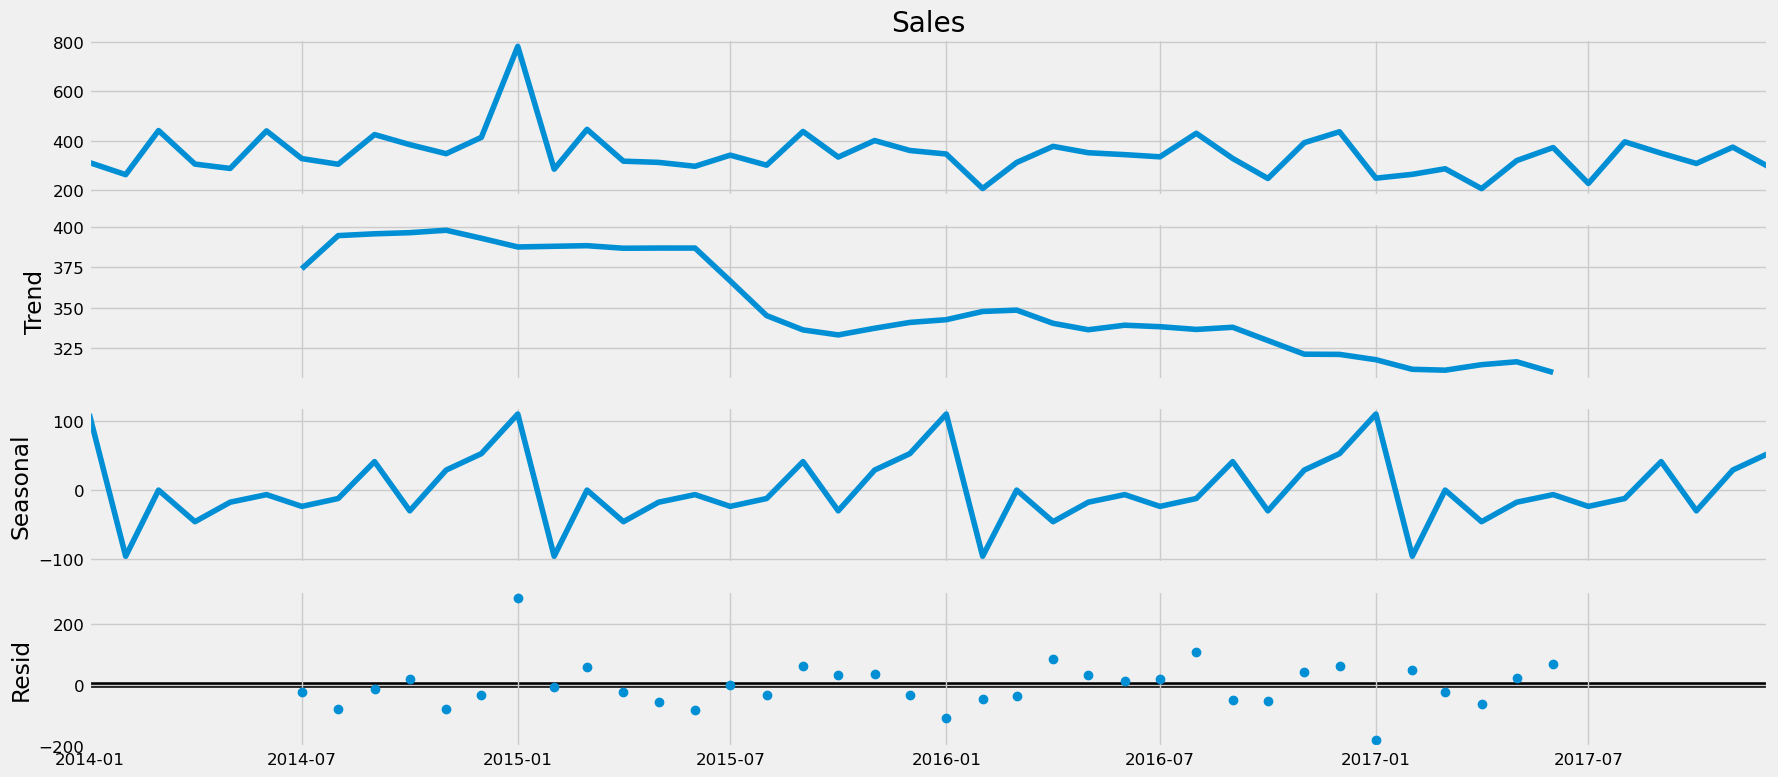

In [9]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

## Time series forecasting with ARIMA

In [1]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

NameError: name 'itertools' is not defined

In [11]:
best_aic = np.inf
best_params = None
best_seasonal_params = None

warnings.filterwarnings("ignore") # specify to ignore warning messages
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            # enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = param
                best_seasonal_params = param_seasonal
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:702.6705312928079
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1810.7800074793604
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:453.97537874517474
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:445.70342838007895
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:628.5073497924994
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1698.7120643189305
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:449.85654362896156
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:447.6654317240236
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:668.1480179335385
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1853.767185098238
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:455.46079304151624
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:447.6052341714685
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:623.1645142919439
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1665.008296901975
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:451.7948630420454
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:449.5456441124988
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:592.3531323020196
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1665.9769659019396
ARI

In [12]:
print('Best model: ARIMA{}x{}12 - AIC:{}'.format(best_params, best_seasonal_params, best_aic))

Best model: ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:438.08244547298744


### Fitting the ARIMA model

In [13]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=best_params,
                                seasonal_order=best_seasonal_params,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0000   1897.570     -0.001      1.000   -3720.169    3718.169
ma.S.L12      -1.0000   1897.637     -0.001      1.000   -3720.299    3718.299
sigma2      7504.4494      0.181   4.15e+04      0.000    7504.095    7504.804


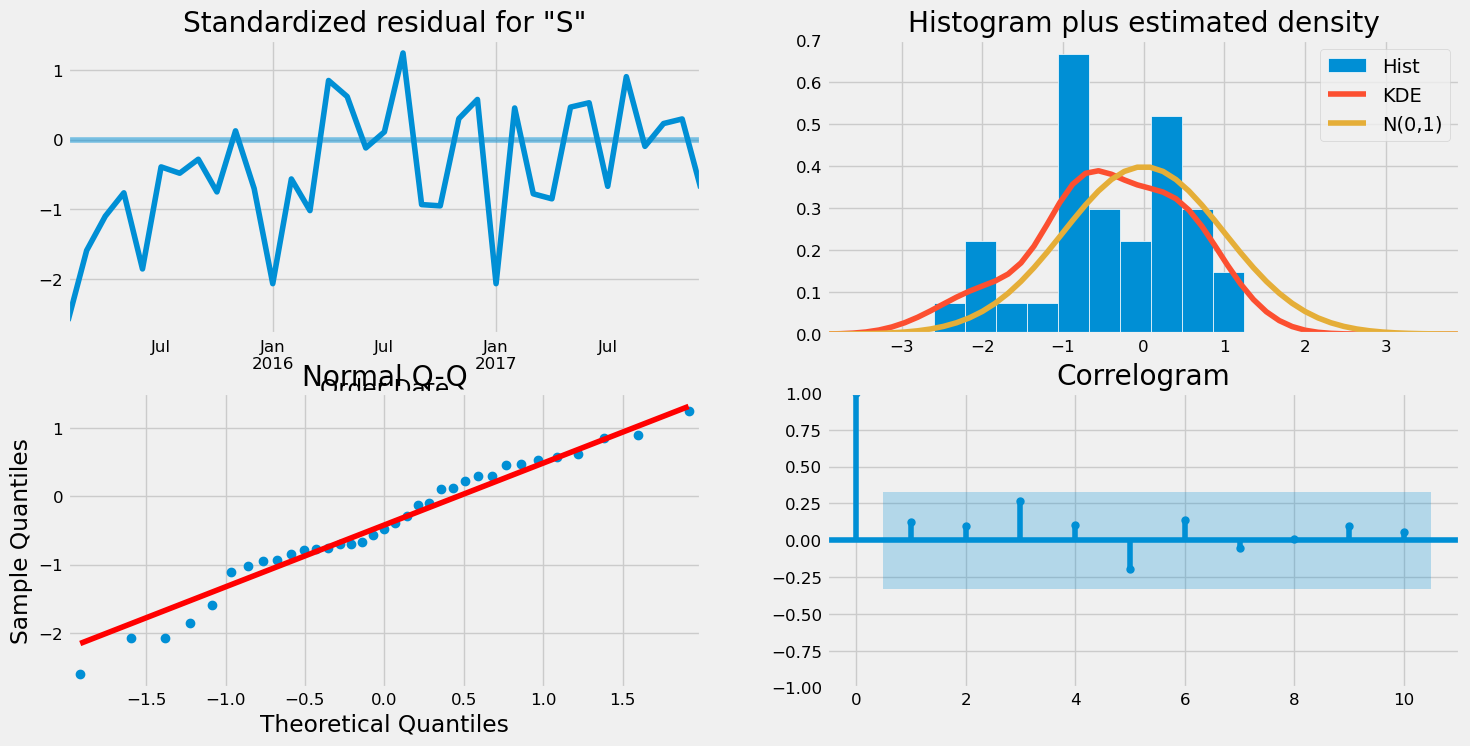

In [14]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

### Validating forecasts

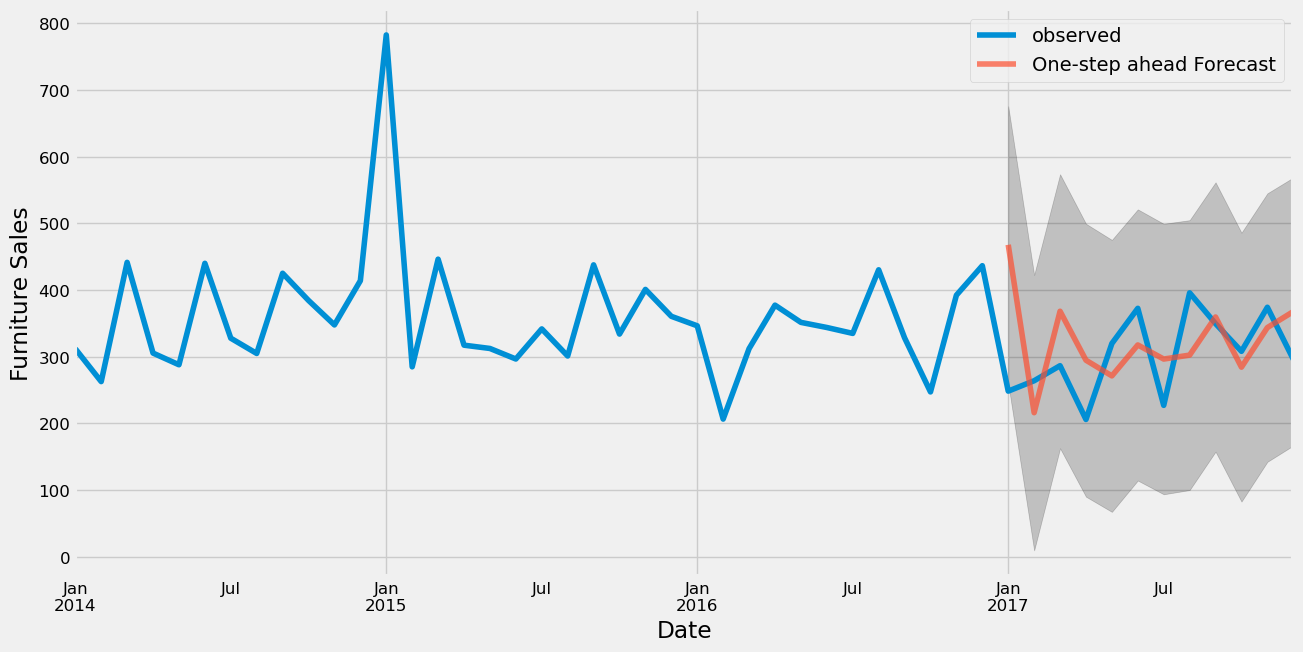

In [15]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [16]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 7555.04


In [17]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 86.92


### Producing and visualizing forecasts

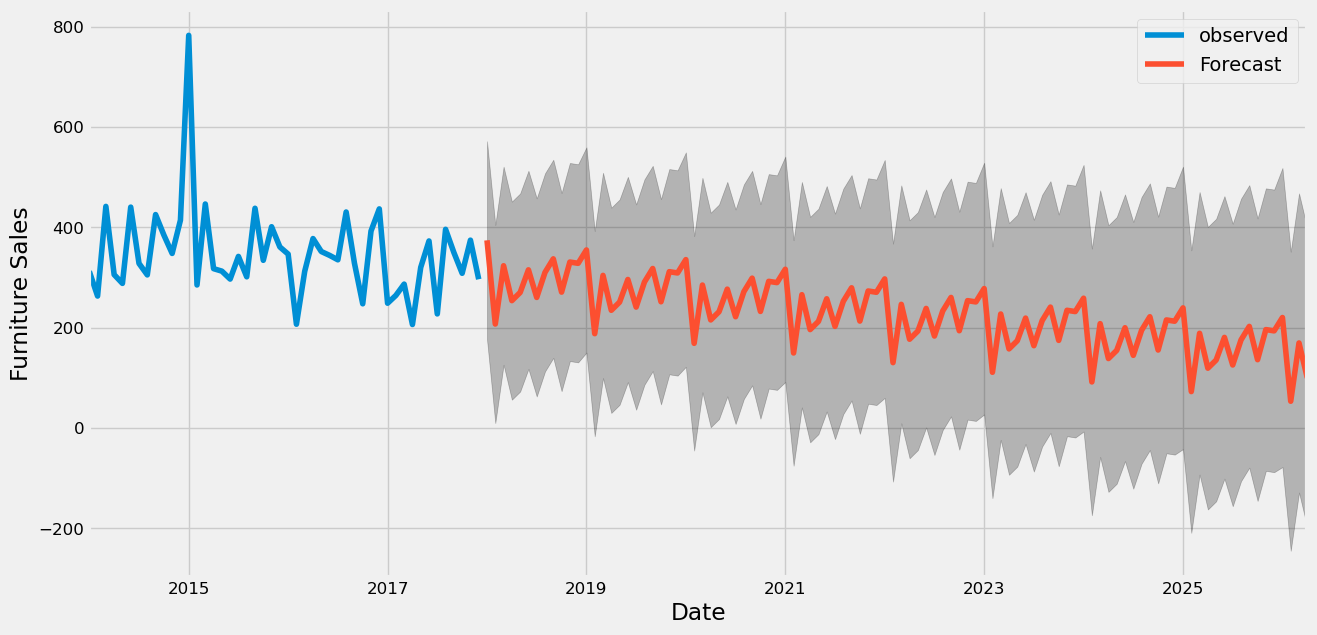

In [18]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

## Time Series of Furniture vs. Office Supplies

In [19]:
furniture = df.loc[df['Category'] == 'Furniture']
office = df.loc[df['Category'] == 'Office Supplies']
furniture.shape, office.shape

((2121, 21), (6026, 21))

### Data Exploration

In [20]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
office.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()
furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')
y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()
furniture = pd.DataFrame({'Order Date':y_furniture.index, 'Sales':y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 'Sales': y_office.values})
store = furniture.merge(office, how='inner', on='Order Date')
store.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales'}, inplace=True)
store.head()

,Order Date,furniture_sales,office_sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


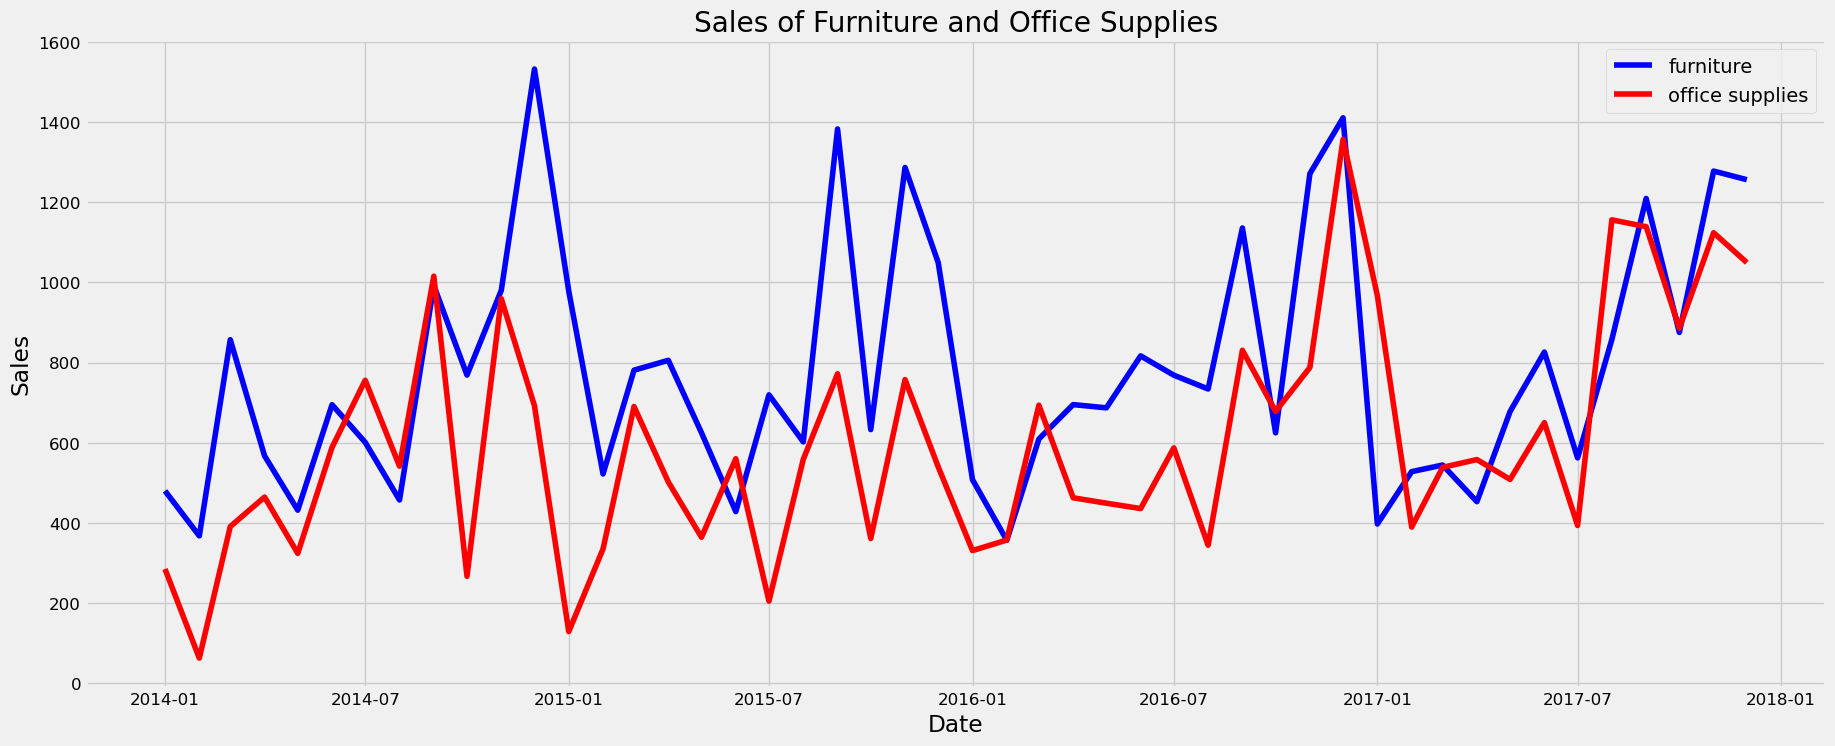

In [21]:
plt.figure(figsize=(20, 8))
plt.plot(store['Order Date'], store['furniture_sales'], 'b-', label = 'furniture')
plt.plot(store['Order Date'], store['office_sales'], 'r-', label = 'office supplies')
plt.xlabel('Date'); plt.ylabel('Sales'); plt.title('Sales of Furniture and Office Supplies')
plt.legend();

In [25]:
first_date = store.loc[np.min(list(np.where(store['office_sales'] > store['furniture_sales'])[0])), 'Order Date']
print("Office supplies first time produced higher sales than furniture is {}.".format(first_date.date()))

Office supplies first time produced higher sales than furniture is 2014-07-01.


### Time Series Modeling with Prophet

In [31]:
from prophet import Prophet

furniture = furniture.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
furniture_model = Prophet(interval_width=0.95)
furniture_model.fit(furniture)

office = office.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
office_model = Prophet(interval_width=0.95)
office_model.fit(office)

furniture_forecast = furniture_model.make_future_dataframe(periods=36, freq='MS')
furniture_forecast = furniture_model.predict(furniture_forecast)

office_forecast = office_model.make_future_dataframe(periods=36, freq='MS')
office_forecast = office_model.predict(office_forecast)

Importing plotly failed. Interactive plots will not work.
17:45:58 - cmdstanpy - INFO - Chain [1] start processing
17:45:59 - cmdstanpy - INFO - Chain [1] done processing
17:45:59 - cmdstanpy - INFO - Chain [1] start processing
17:45:59 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1800x600 with 0 Axes>

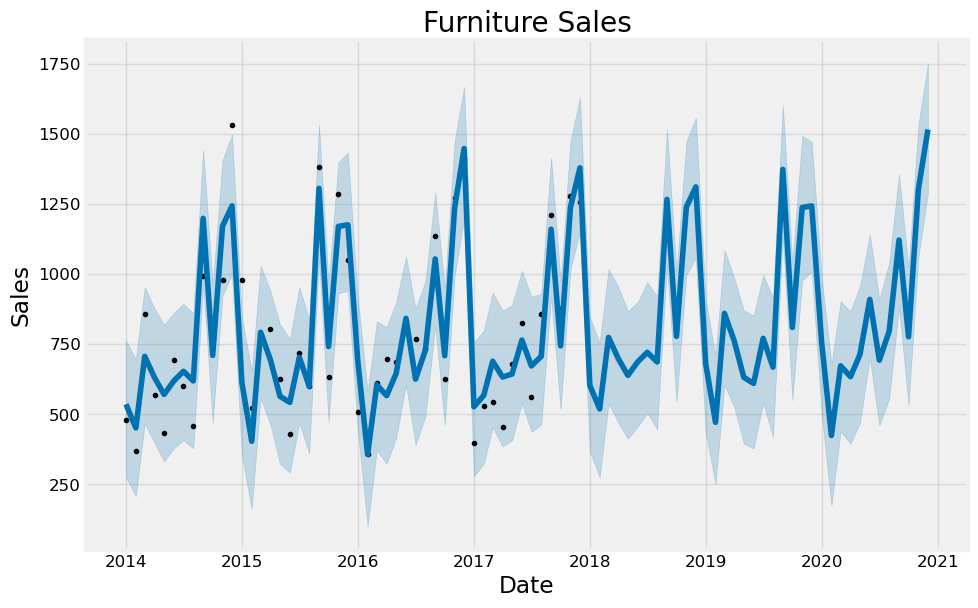

In [32]:
plt.figure(figsize=(18, 6))
furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales');

<Figure size 1800x600 with 0 Axes>

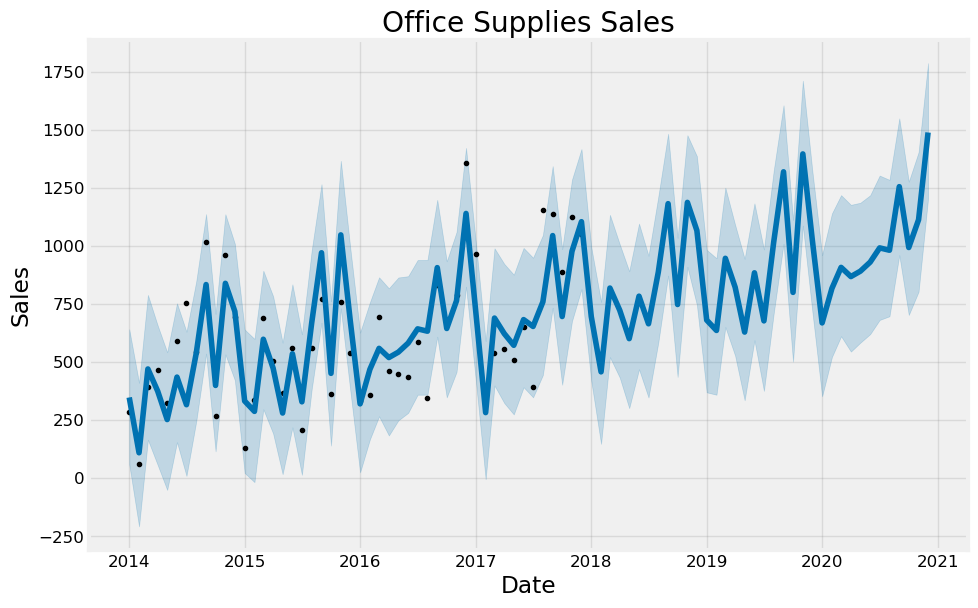

In [33]:
plt.figure(figsize=(18, 6))
office_model.plot(office_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Office Supplies Sales');

In [34]:
furniture_names = ['furniture_%s' % column for column in furniture_forecast.columns]
office_names = ['office_%s' % column for column in office_forecast.columns]
merge_furniture_forecast = furniture_forecast.copy()
merge_office_forecast = office_forecast.copy()
merge_furniture_forecast.columns = furniture_names
merge_office_forecast.columns = office_names
forecast = pd.merge(merge_furniture_forecast, merge_office_forecast, how = 'inner', left_on = 'furniture_ds', right_on = 'office_ds')
forecast = forecast.rename(columns={'furniture_ds': 'Date'}).drop('office_ds', axis=1)
forecast.head()

,Date,furniture_trend,furniture_yhat_lower,furniture_yhat_upper,furniture_trend_lower,furniture_trend_upper,furniture_additive_terms,furniture_additive_terms_lower,furniture_additive_terms_upper,furniture_yearly,...,office_additive_terms,office_additive_terms_lower,office_additive_terms_upper,office_yearly,office_yearly_lower,office_yearly_upper,office_multiplicative_terms,office_multiplicative_terms_lower,office_multiplicative_terms_upper,office_yhat
0,2014-01-01,726.058109,274.169632,761.523610,726.058109,726.058109,-190.686099,-190.686099,-190.686099,-190.686099,...,-140.041115,-140.041115,-140.041115,-140.041115,-140.041115,-140.041115,0.0,0.0,0.0,347.489370
1,2014-02-01,727.494421,207.563546,697.280461,727.494421,727.494421,-276.379157,-276.379157,-276.379157,-276.379157,...,-385.677761,-385.677761,-385.677761,-385.677761,-385.677761,-385.677761,0.0,0.0,0.0,109.240405
2,2014-03-01,728.791734,466.794551,954.435790,728.791734,728.791734,-22.388253,-22.388253,-22.388253,-22.388253,...,-31.378526,-31.378526,-31.378526,-31.378526,-31.378526,-31.378526,0.0,0.0,0.0,470.212385
3,2014-04-01,730.228046,397.497107,876.675065,730.228046,730.228046,-100.140909,-100.140909,-100.140909,-100.140909,...,-134.290665,-134.290665,-134.290665,-134.290665,-134.290665,-134.290665,0.0,0.0,0.0,374.687928
4,2014-05-01,731.618025,331.402401,819.629529,731.618025,731.618025,-160.818882,-160.818882,-160.818882,-160.818882,...,-263.823552,-263.823552,-263.823552,-263.823552,-263.823552,-263.823552,0.0,0.0,0.0,252.304409


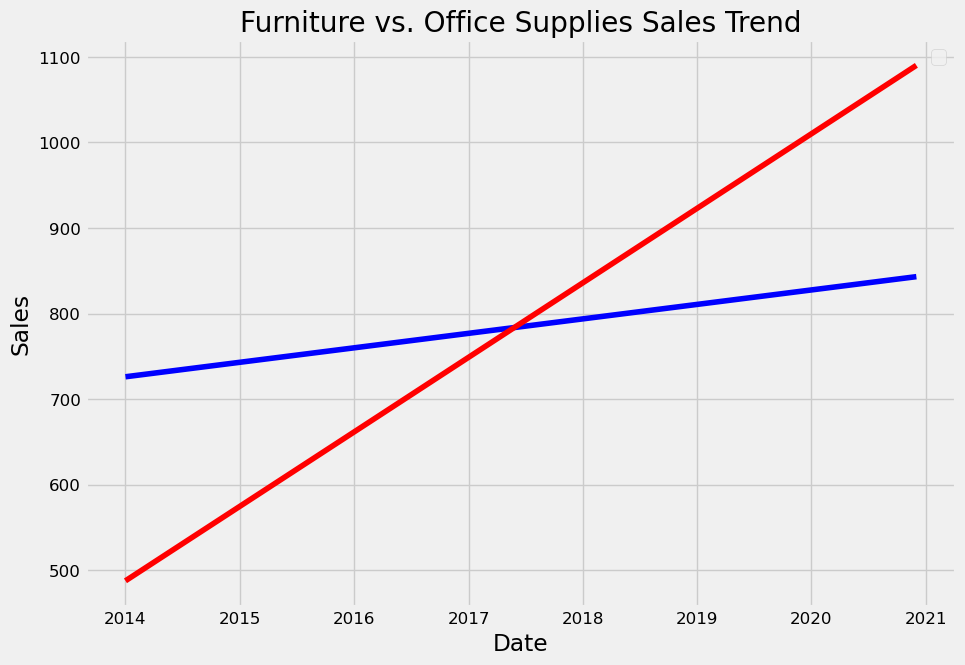

In [35]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_trend'], 'b-')
plt.plot(forecast['Date'], forecast['office_trend'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Sales Trend');

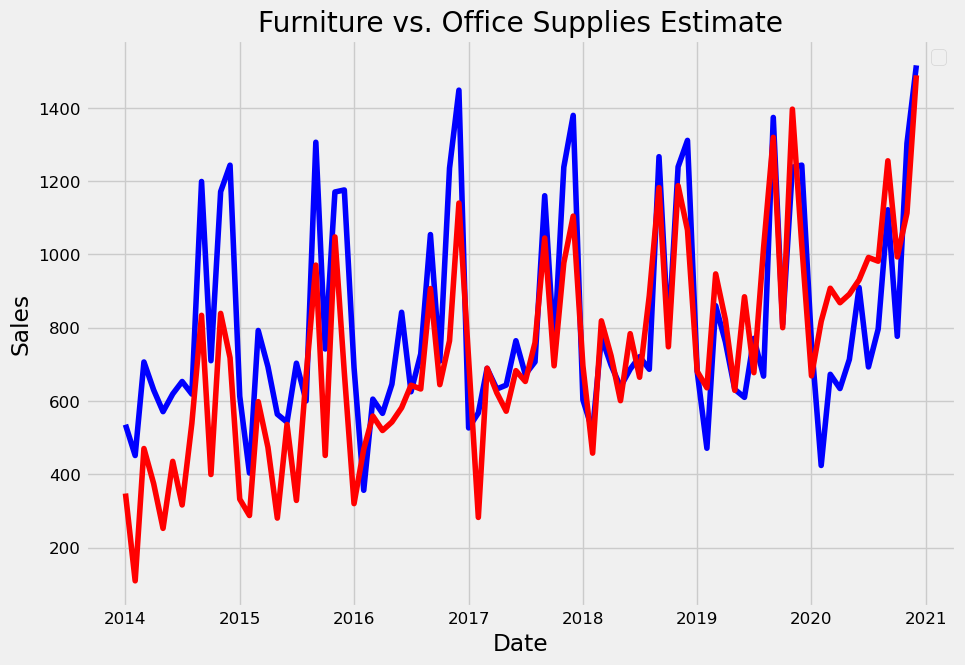

In [37]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['office_yhat'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Estimate');

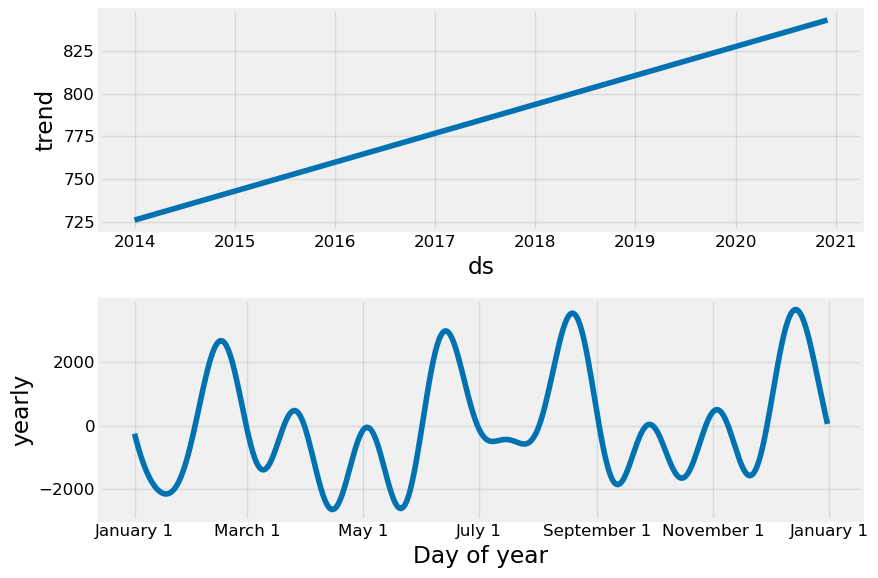

In [38]:
furniture_model.plot_components(furniture_forecast);

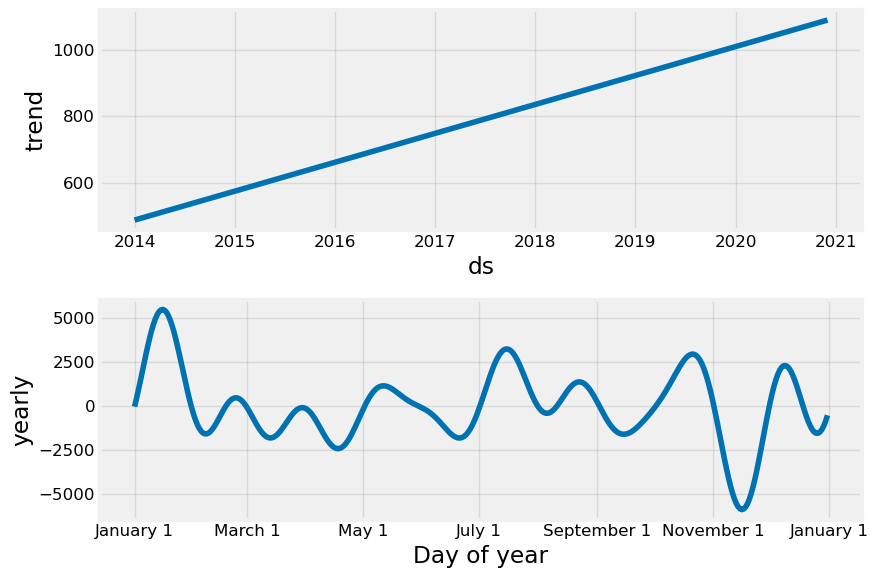

In [41]:
office_model.plot_components(office_forecast);